This file corresponds to Scenario 1 from the publication "Can machine learning extract the mechanisms controlling phytoplankton growth from large-scale observations? – A proof-of-concept study" by Holder and Gnanadesikan (2021).

The Zenodo file and the code published with the manuscript were implemented in MATLAB, so the results, graphs, and tables may have slightly different numbers or appearances. However, this is simply due to differences in things such as the random number generator used in Python vs MATLAB or differences in some of the optimatization settings in the machine learning methods. While I do try to get the machine learning parameters here as close as possible to the ones used in MATLAB, there will be small differences but the results can be interpreted in the same way.

First we're going to create a local directory for the data (if it doesn't exist yet) and then download and extract the data from the Zenodo repository.

In [2]:
import os
import zipfile
from zenodo_get import zenodo_get

# Create local directory for the netCDF files, if it doesn't already exist

cur_dir = os.getcwd()
data_dir = os.path.join(cur_dir,r'20210205_LinkingIntrinsicAndApparentRelationships')
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    
# Download the zip file from the Zenodo repository

zenodo_get(['-d','10.5281/zenodo.4511337'])

# Extract the contents (netCDF files) of the zip file to the local directory

with zipfile.ZipFile("20210205_LinkingIntrinsicAndApparentRelationships.zip","r") as zip_ref:
    zip_ref.extractall("20210205_LinkingIntrinsicAndApparentRelationships")

Title: Dataset and scripts for manuscript "Can machine learning extract the mechanisms controlling phytoplankton growth from large-scale observations? – A proof of concept study"
Keywords: 
Publication date: 2020-07-07
DOI: 10.5281/zenodo.4511337
Total size: 389.7 MB

Link: https://zenodo.org/api/files/5e9b5bba-18ce-448f-9e43-fc62a09f6edb/20210205_LinkingIntrinsicAndApparentRelationships.zip   size: 389.7 MB
20210205_LinkingIntrinsicAndApparentRelationships.zip is already downloaded correctly.
All files have been downloaded.


Now that we've downloaded and extracted the data, lets open the relevant variables from the netCDF files: latitude (lat), longitude (lon), time in months (time_initial), phosphate (po4), dissolved iron (fed), and irradiance of the mixed layer (irr_mix).

The latitude, longitude, and time variables are vectors. The phosphate, dissolved iron, and irradiance are 4-dimensional arrays corresponding to latitude, longitude, time, and depth. In the publication, only the surface layer is used so this reduces to a 3-dimensional array and gets rid of the "depth" dimension.

In [3]:
import math
import netCDF4 as nc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing

# Specify current directory and directory with data files

cur_dir = os.getcwd()
data_dir = os.path.join(cur_dir,r'20210205_LinkingIntrinsicAndApparentRelationships')
    
# Name of the Scenario 1 netCDF Source File
    
s1_source_file = 'Scenario1SourceFile.nc'

# Assign the data to the proper variable and assign names; most of the
# variables have latitude, longitude, month, and depth; for Scenario 1
# we are just using the surface values where depth=1

data = nc.Dataset(os.path.join(data_dir,s1_source_file))

lat = data['GEOLAT_T'][:]
lon = data['GEOLON_T'][:]
time_initial = data['TIME'][:]

po4 = data['PO4'][:]
po4 = np.squeeze(po4)

fed = data['FED'][:]
fed = np.squeeze(fed)

irr_mix = data['IRR_MIX'][:]
irr_mix = np.squeeze(irr_mix)

Next, let's calculate the limitation terms for the phytoplankton. These are essentially the equations which will govern our simple phytoplankton model. Pstar (or P* in the publication) is simply a scaling factor to put the phytoplankton biomass in specific units.

The limitation terms basically constrain (or limit) the growth of the phytoplankton. As the concentration of one of the nutrients increases, it has diminishing returns for the phytoplankton since their biological need for specific nutrients is met. These types of growth patterns are termed "Michaelis-Menten" curves. 

The constants in the denominator of each equation is what's known as the half-saturation coefficients and this determines where the curve levels off.

We use the information from the netCDF files we extracted as the concentrations for the limitation terms below. For example, we can take each of the phosphate concentrations from the netCDF file and determine the phosphate limitation term in each time and location.

In [4]:
# Calculate the limitation terms based on the inputs from phosphate, iron, and light

phoslim = po4/(1e-7+po4)
ironlim = fed/(2e-10+fed)
lightlim = irr_mix/(34.3+irr_mix)

Now we have limitation terms, but they are still independent of one another. So let's combine them in equations to calculate the biomass of phytoplankton for each time and location.

The way the model works is fairly simple. The values of the phosphate limitation are compared to the dissolved iron limitation for each latitude/longitude pair for each month. Whichever one of them is smaller is then multiplied by the irradiance limitation and the pstar scaling factor. This is because the smaller of the two is acting as the limiting factor controlling the phytoplankton biomass. For example, if the phytoplankton are limited by the phosphate they stop growing regardless of how much dissolved iron we continue to add past that.

In [5]:
# Initialize the biomass matrix and then calculate the biomass

bio = np.empty((12,80,120))*np.nan

pstar = 1.9e-6 # Scaling constant

for i in range(12):
    for j in range(80):
        for k in range(120):
            if phoslim[i,j,k] < ironlim[i,j,k]:
                bio[i,j,k] = pstar*phoslim[i,j,k]*lightlim[i,j,k]
            elif ironlim[i,j,k] < phoslim[i,j,k]:
                bio[i,j,k] = pstar*ironlim[i,j,k]*lightlim[i,j,k]

Congratulations! You just ran a phytoplankton nutrient model!

Now we have the data of each observation we need for our analysis:
- Index number for each unique latitude/longitude pair for each month
- Latitude value
- Longitude value
- Month
- Phosphate concentration
- Dissolved iron concentration
- Irradiance value
- Biomass concentration

In the code below and in the publication, we refer to the phosphate concentration as the macronutrient and the dissolved iron as the micronutrient. This is because phosphate is generally needed in much larger quantities compared to dissolved iron. For reference, just look at the half-saturation coefficients in the limitation equations from earlier; the constants phosphate and dissolved iron differ by three orders of magnitude!

Now we need to put the data into a form that we can give to each machine learning technique. So let's take the data that we have that's currently in a bunch of separate variables and combine them into a single array with each observation being its own row and each variable being its own column.

In [6]:
# Create lists for the variable names and their respective units

variables = ['Index','Latitude','Longitude','Month','Macronutrient','Micronutrient','Irradiance','Biomass']
units = ['','degrees E','degrees N','','mol/kg','mol/kg','W/m2','mol/kg']

# Give a unique index number to each lat/lon pair and reshape it into a 120x80 array

index_matrix = range(1,9601)
index_matrix = np.reshape(index_matrix,(120,80))

# Initialize the array that will contain all of the combined data

final = np.empty((120*80*12,8))*np.nan

# Move the values from each variable into a column corresponding to the correct
# latitude, longitude, and month; this creates a matrix where each column corresponds
# to a variable and each row corresponds to an observation

for i in range(12):
    for j in range(80):
        for k in range(120):
            index_number = index_matrix[k,j]
            final[index_number+((i-1)*9600),0] = index_number + ((i-1)*9600)
            final[index_number+((i-1)*9600),1] = lat[j,k]
            final[index_number+((i-1)*9600),2] = lon[j,k]
            final[index_number+((i-1)*9600),3] = time_initial[i]
            final[index_number+((i-1)*9600),4] = po4[i,j,k]
            final[index_number+((i-1)*9600),5] = fed[i,j,k]
            final[index_number+((i-1)*9600),6] = irr_mix[i,j,k]
            final[index_number+((i-1)*9600),7] = bio[i,j,k]
            
# Get rid of any rows that have NaN (not-a-number) values

final = final[~np.isnan(final).any(axis=1),:]

# Turn the numpy array into a dataframe with the columns have labels corresponding to
# the variable names

final = pd.DataFrame(final,columns=variables)

C:\Users\holde\AppData\Local\Temp\ipykernel_6112\702304130.py:27: UserWarning: Warning: converting a masked element to nan.
  final[index_number+((i-1)*9600),4] = po4[i,j,k]
C:\Users\holde\AppData\Local\Temp\ipykernel_6112\702304130.py:28: UserWarning: Warning: converting a masked element to nan.
  final[index_number+((i-1)*9600),5] = fed[i,j,k]
C:\Users\holde\AppData\Local\Temp\ipykernel_6112\702304130.py:29: UserWarning: Warning: converting a masked element to nan.
  final[index_number+((i-1)*9600),6] = irr_mix[i,j,k]


The flag above stating "UserWarning: Warning: converting a masked element to nan" just means that it is transforming the "--" values in the variables that represent land into NaNs.

Now we'll specify which columns/variables are the response/target variables and which are the predictors.

In [7]:
# Specify the response and predictor columns

Y = [7]
X = [4,5,6]

Y_labels = ['Biomass']
X_labels = ['Macronutrient','Micronutrient','Irradiance']

Now we'll split the data into training, testing, and validation datasets. Then we'll scale all so that each of the subsets is between -1 and 1. This makes training for the neural network ensemble faster. Although it isn't required for the multiple linear regression and random forest method, we keep the -1 to 1 range for consistency.

In [8]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Split data into training, testing, and validation datasets

X_train, X_test, Y_train, Y_test = train_test_split(final[X_labels],final[Y_labels],test_size=0.2,random_state=123) # 20% of data goes to testing dataset
X_train, X_val, Y_train, Y_val = train_test_split(X_train,Y_train,test_size=0.125,random_state=123) # 70% of data goes to training dataset and 10% goes to the validation dataset

# Scale the data between -1 and 1

scaler_x = preprocessing.MinMaxScaler(feature_range=(-1,1)).fit(final[X_labels])
scaler_y = preprocessing.MinMaxScaler(feature_range=(-1,1)).fit(final[Y_labels])
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.fit_transform(X_test)
X_val = scaler_x.fit_transform(X_val)
Y_train = scaler_y.fit_transform(Y_train)
Y_test = scaler_y.fit_transform(Y_test)
Y_val = scaler_y.fit_transform(Y_val)

Now that we have the data prepped, let's run the multiple linear regression (MLR) model and calculate the R2 value and RMSE for the training and testing datasets.

In [14]:
# Train the MLR model with the training data

Mdl_mlr = LinearRegression()
Mdl_mlr.fit(X_train,Y_train)

# Get predictions for the training data and compared to the true values

mlr_train_pred = Mdl_mlr.predict(X_train)
mlr_train_pred = scaler_y.inverse_transform(mlr_train_pred)
mlr_train_true = scaler_y.inverse_transform(Y_train)

mlr_r2_train = metrics.r2_score(mlr_train_true,mlr_train_pred)
mlr_rmse_train = metrics.mean_squared_error(mlr_train_true,mlr_train_pred,squared=False)

# Get predictions for the testing data and compare to the true values

mlr_test_pred = Mdl_mlr.predict(X_test)
mlr_test_pred = scaler_y.inverse_transform(mlr_test_pred)
mlr_test_true = scaler_y.inverse_transform(Y_test)

mlr_r2_test = metrics.r2_score(mlr_test_true,mlr_test_pred)
mlr_rmse_test = metrics.mean_squared_error(mlr_test_true,mlr_test_pred,squared=False)

# Print the performance results

print("Multiple Linear Regression R2 (Training Data):",mlr_r2_train)
print("Multiple Linear Regression RMSE (Training Data):",mlr_rmse_train)
print("Multiple Linear Regression R2 (Testing Data):",mlr_r2_test)
print("Multiple Linear Regression RMSE (Testing Data):",mlr_rmse_test)

Multiple Linear Regression R2 (Training Data): 0.41268510356251276
Multiple Linear Regression RMSE (Training Data): 1.0443561960587149e-07
Multiple Linear Regression R2 (Testing Data): 0.41337495890928255
Multiple Linear Regression RMSE (Testing Data): 1.0778508109750825e-07


Now let's train the random forest (RF) model and calculate the R2 and RMSE like we did for the MLR model.

Note: The number of trees (n_estimators) and the minimum number of samples per terminal leaf (min_samples_leaf) were optimized in the original publication. For more information, please look to the appendix in the original publication.

In [15]:
# Train the RF model with the training data

Mdl_rf = RandomForestRegressor(n_estimators=500,random_state=123,min_samples_leaf=5,max_features=1)
Mdl_rf.fit(X_train,Y_train.ravel())

# Get the predictions for the training data and compare to the true values

rf_train_pred = Mdl_rf.predict(X_train)
rf_train_pred = scaler_y.inverse_transform(rf_train_pred.reshape(-1,1))
rf_train_true = scaler_y.inverse_transform(Y_train)

rf_r2_train = metrics.r2_score(rf_train_true,rf_train_pred)
rf_rmse_train = metrics.mean_squared_error(rf_train_true,rf_train_pred,squared=False)

# Get the predictions for the testing data and compare to the true values

rf_test_pred = Mdl_rf.predict(X_test)
rf_test_pred = scaler_y.inverse_transform(rf_test_pred.reshape(-1,1))
rf_test_true = scaler_y.inverse_transform(Y_test)

rf_r2_test = metrics.r2_score(rf_test_true,rf_test_pred)
rf_rmse_test = metrics.mean_squared_error(rf_test_true,rf_test_pred,squared=False)

# Print the performance results

print("Random Forest R2 (Training Data):",rf_r2_train)
print("Random Forest RMSE (Training Data):",rf_rmse_train)
print("Random Forest R2 (Testing Data):",rf_r2_test)
print("Random Forest RMSE (Testing Data):",rf_rmse_test)

Random Forest R2 (Training Data): 0.9982787514852048
Random Forest RMSE (Training Data): 5.653728234637375e-09
Random Forest R2 (Testing Data): 0.9944755282257562
Random Forest RMSE (Testing Data): 1.0459808501009242e-08


Now let's train the neural network ensemble (NNE). A NNE is simply a collection of individual neural networks with the same architecture.

One neural network is trained on a subset of the training data, then the data is reallocated and another neural network is trained. The process is repeated for however many neural networks are specified.

The hyperparameters in the following code are setup for speed and so this code can be published to GitHub for demonstrations. To improve the accuracy and more accurately capture what was shown in the publication, change the batch_size parameter or the number of epochs to a higher number. Other hyperparameters can be adjusted but this will cause them to be different compared to the MATLAB code used in the publication.

In [19]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

NNE_num = 5
Mdl_nne = [];

for i in range(NNE_num):
    X_train, X_test, Y_train, Y_test = train_test_split(final[X_labels],final[Y_labels],test_size=0.2,random_state=123)
    X_train, X_val, Y_train, Y_val = train_test_split(X_train,Y_train,test_size=0.125,random_state=123*i)
    
    scaler_x = preprocessing.MinMaxScaler(feature_range=(-1,1)).fit(final[X_labels])
    scaler_y = preprocessing.MinMaxScaler(feature_range=(-1,1)).fit(final[Y_labels])
    X_train = scaler_x.fit_transform(X_train)
    X_test = scaler_x.fit_transform(X_test)
    X_val = scaler_x.fit_transform(X_val)
    Y_train = scaler_y.fit_transform(Y_train)
    Y_test = scaler_y.fit_transform(Y_test)
    Y_val = scaler_y.fit_transform(Y_val)
    
    print(i)

    e_stop = EarlyStopping(monitor='val_loss',mode='min',patience=6,verbose=1)

    Mdl_ann = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(3,)),
        tf.keras.layers.Dense(25,activation='sigmoid'),
        tf.keras.layers.Dense(1,activation='linear')
    ])
    
    Mdl_nne.append(Mdl_ann)

    Mdl_nne[i].compile(optimizer='adam',loss='mse')

    Mdl_nne[i].fit(X_train,Y_train,batch_size=250,epochs=1000,verbose=2,shuffle=False,callbacks=[e_stop],validation_data=(X_val,Y_val))

nne_train_pred = [];
nne_test_pred = [];

X_train, X_test, Y_train, Y_test = train_test_split(final[X_labels],final[Y_labels],test_size=0.2,random_state=123)
X_train, X_val, Y_train, Y_val = train_test_split(X_train,Y_train,test_size=0.125,random_state=123)

scaler_x = preprocessing.MinMaxScaler(feature_range=(-1,1)).fit(final[X_labels])
scaler_y = preprocessing.MinMaxScaler(feature_range=(-1,1)).fit(final[Y_labels])
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.fit_transform(X_test)
X_val = scaler_x.fit_transform(X_val)
Y_train = scaler_y.fit_transform(Y_train)
Y_test = scaler_y.fit_transform(Y_test)
Y_val = scaler_y.fit_transform(Y_val)

for i in range(NNE_num):
    nne_train_pred.append(Mdl_nne[i].predict(X_train))
    nne_train_pred[i] = scaler_y.inverse_transform(nne_train_pred[i])
    
    nne_test_pred.append(Mdl_nne[i].predict(X_test))
    nne_test_pred[i] = scaler_y.inverse_transform(nne_test_pred[i])
    
nne_train_pred_avg = np.mean(nne_train_pred,axis=0)
nne_test_pred_avg = np.mean(nne_test_pred,axis=0)

nne_train_true = scaler_y.inverse_transform(Y_train)
nne_test_true = scaler_y.inverse_transform(Y_test)

nne_r2_train = metrics.r2_score(nne_train_true,nne_train_pred_avg)
nne_rmse_train = metrics.mean_squared_error(nne_train_true,nne_train_pred_avg,squared=False)
    
nne_r2_test = metrics.r2_score(nne_test_true,nne_test_pred_avg)
nne_rmse_test = metrics.mean_squared_error(nne_test_true,nne_test_pred_avg,squared=False)

print("Neural Network Ensemble R2 (Training Data):",nne_r2_train)
print("Neural Network Ensemble RMSE (Training Data):",nne_rmse_train)
print("Neural Network Ensemble R2 (Testing Data):",nne_r2_test)
print("Neural Network Ensemble RMSE (Testing Data):",nne_rmse_test)

0
Epoch 1/1000
217/217 - 1s - loss: 0.2177 - val_loss: 0.0928
Epoch 2/1000
217/217 - 0s - loss: 0.0878 - val_loss: 0.0844
Epoch 3/1000
217/217 - 0s - loss: 0.0822 - val_loss: 0.0818
Epoch 4/1000
217/217 - 0s - loss: 0.0802 - val_loss: 0.0810
Epoch 5/1000
217/217 - 0s - loss: 0.0795 - val_loss: 0.0808
Epoch 6/1000
217/217 - 0s - loss: 0.0791 - val_loss: 0.0806
Epoch 7/1000
217/217 - 0s - loss: 0.0788 - val_loss: 0.0803
Epoch 8/1000
217/217 - 0s - loss: 0.0784 - val_loss: 0.0799
Epoch 9/1000
217/217 - 0s - loss: 0.0780 - val_loss: 0.0794
Epoch 10/1000
217/217 - 0s - loss: 0.0774 - val_loss: 0.0787
Epoch 11/1000
217/217 - 0s - loss: 0.0766 - val_loss: 0.0778
Epoch 12/1000
217/217 - 0s - loss: 0.0754 - val_loss: 0.0765
Epoch 13/1000
217/217 - 0s - loss: 0.0739 - val_loss: 0.0748
Epoch 14/1000
217/217 - 0s - loss: 0.0719 - val_loss: 0.0726
Epoch 15/1000
217/217 - 0s - loss: 0.0694 - val_loss: 0.0700
Epoch 16/1000
217/217 - 0s - loss: 0.0666 - val_loss: 0.0672
Epoch 17/1000
217/217 - 0s - lo

Epoch 135/1000
217/217 - 0s - loss: 0.0293 - val_loss: 0.0292
Epoch 136/1000
217/217 - 0s - loss: 0.0292 - val_loss: 0.0291
Epoch 137/1000
217/217 - 0s - loss: 0.0291 - val_loss: 0.0290
Epoch 138/1000
217/217 - 0s - loss: 0.0290 - val_loss: 0.0289
Epoch 139/1000
217/217 - 0s - loss: 0.0289 - val_loss: 0.0288
Epoch 140/1000
217/217 - 0s - loss: 0.0288 - val_loss: 0.0287
Epoch 141/1000
217/217 - 0s - loss: 0.0287 - val_loss: 0.0286
Epoch 142/1000
217/217 - 0s - loss: 0.0286 - val_loss: 0.0285
Epoch 143/1000
217/217 - 0s - loss: 0.0285 - val_loss: 0.0283
Epoch 144/1000
217/217 - 0s - loss: 0.0284 - val_loss: 0.0282
Epoch 145/1000
217/217 - 0s - loss: 0.0283 - val_loss: 0.0281
Epoch 146/1000
217/217 - 0s - loss: 0.0282 - val_loss: 0.0280
Epoch 147/1000
217/217 - 0s - loss: 0.0281 - val_loss: 0.0279
Epoch 148/1000
217/217 - 0s - loss: 0.0279 - val_loss: 0.0278
Epoch 149/1000
217/217 - 0s - loss: 0.0278 - val_loss: 0.0277
Epoch 150/1000
217/217 - 0s - loss: 0.0277 - val_loss: 0.0275
Epoch 15

217/217 - 0s - loss: 0.0176 - val_loss: 0.0211
Epoch 268/1000
217/217 - 0s - loss: 0.0176 - val_loss: 0.0210
Epoch 269/1000
217/217 - 0s - loss: 0.0175 - val_loss: 0.0210
Epoch 270/1000
217/217 - 0s - loss: 0.0175 - val_loss: 0.0209
Epoch 271/1000
217/217 - 0s - loss: 0.0174 - val_loss: 0.0209
Epoch 272/1000
217/217 - 0s - loss: 0.0174 - val_loss: 0.0209
Epoch 273/1000
217/217 - 0s - loss: 0.0173 - val_loss: 0.0208
Epoch 274/1000
217/217 - 0s - loss: 0.0173 - val_loss: 0.0208
Epoch 275/1000
217/217 - 0s - loss: 0.0172 - val_loss: 0.0207
Epoch 276/1000
217/217 - 0s - loss: 0.0172 - val_loss: 0.0207
Epoch 277/1000
217/217 - 0s - loss: 0.0171 - val_loss: 0.0207
Epoch 278/1000
217/217 - 0s - loss: 0.0171 - val_loss: 0.0206
Epoch 279/1000
217/217 - 0s - loss: 0.0170 - val_loss: 0.0206
Epoch 280/1000
217/217 - 0s - loss: 0.0170 - val_loss: 0.0205
Epoch 281/1000
217/217 - 0s - loss: 0.0169 - val_loss: 0.0205
Epoch 282/1000
217/217 - 0s - loss: 0.0169 - val_loss: 0.0204
Epoch 283/1000
217/217 

Epoch 400/1000
217/217 - 0s - loss: 0.0122 - val_loss: 0.0162
Epoch 401/1000
217/217 - 0s - loss: 0.0121 - val_loss: 0.0162
Epoch 402/1000
217/217 - 0s - loss: 0.0121 - val_loss: 0.0162
Epoch 403/1000
217/217 - 0s - loss: 0.0121 - val_loss: 0.0162
Epoch 404/1000
217/217 - 0s - loss: 0.0120 - val_loss: 0.0161
Epoch 405/1000
217/217 - 0s - loss: 0.0120 - val_loss: 0.0161
Epoch 406/1000
217/217 - 0s - loss: 0.0120 - val_loss: 0.0161
Epoch 407/1000
217/217 - 0s - loss: 0.0119 - val_loss: 0.0160
Epoch 408/1000
217/217 - 0s - loss: 0.0119 - val_loss: 0.0160
Epoch 409/1000
217/217 - 0s - loss: 0.0119 - val_loss: 0.0160
Epoch 410/1000
217/217 - 1s - loss: 0.0118 - val_loss: 0.0160
Epoch 411/1000
217/217 - 1s - loss: 0.0118 - val_loss: 0.0159
Epoch 412/1000
217/217 - 0s - loss: 0.0118 - val_loss: 0.0159
Epoch 413/1000
217/217 - 0s - loss: 0.0117 - val_loss: 0.0159
Epoch 414/1000
217/217 - 0s - loss: 0.0117 - val_loss: 0.0159
Epoch 415/1000
217/217 - 0s - loss: 0.0117 - val_loss: 0.0158
Epoch 41

217/217 - 2s - loss: 0.0092 - val_loss: 0.0143
Epoch 533/1000
217/217 - 0s - loss: 0.0092 - val_loss: 0.0143
Epoch 534/1000
217/217 - 0s - loss: 0.0092 - val_loss: 0.0142
Epoch 535/1000
217/217 - 0s - loss: 0.0091 - val_loss: 0.0142
Epoch 536/1000
217/217 - 0s - loss: 0.0091 - val_loss: 0.0142
Epoch 537/1000
217/217 - 0s - loss: 0.0091 - val_loss: 0.0142
Epoch 538/1000
217/217 - 0s - loss: 0.0091 - val_loss: 0.0142
Epoch 539/1000
217/217 - 0s - loss: 0.0091 - val_loss: 0.0142
Epoch 540/1000
217/217 - 0s - loss: 0.0091 - val_loss: 0.0142
Epoch 541/1000
217/217 - 0s - loss: 0.0091 - val_loss: 0.0142
Epoch 542/1000
217/217 - 0s - loss: 0.0090 - val_loss: 0.0142
Epoch 543/1000
217/217 - 0s - loss: 0.0090 - val_loss: 0.0142
Epoch 544/1000
217/217 - 0s - loss: 0.0090 - val_loss: 0.0142
Epoch 545/1000
217/217 - 0s - loss: 0.0090 - val_loss: 0.0142
Epoch 546/1000
217/217 - 0s - loss: 0.0090 - val_loss: 0.0141
Epoch 547/1000
217/217 - 0s - loss: 0.0090 - val_loss: 0.0141
Epoch 548/1000
217/217 

Epoch 665/1000
217/217 - 0s - loss: 0.0075 - val_loss: 0.0131
Epoch 666/1000
217/217 - 0s - loss: 0.0075 - val_loss: 0.0131
Epoch 667/1000
217/217 - 0s - loss: 0.0075 - val_loss: 0.0131
Epoch 668/1000
217/217 - 0s - loss: 0.0075 - val_loss: 0.0131
Epoch 669/1000
217/217 - 0s - loss: 0.0075 - val_loss: 0.0131
Epoch 670/1000
217/217 - 0s - loss: 0.0075 - val_loss: 0.0131
Epoch 671/1000
217/217 - 0s - loss: 0.0075 - val_loss: 0.0131
Epoch 672/1000
217/217 - 0s - loss: 0.0074 - val_loss: 0.0131
Epoch 673/1000
217/217 - 0s - loss: 0.0074 - val_loss: 0.0131
Epoch 674/1000
217/217 - 0s - loss: 0.0074 - val_loss: 0.0131
Epoch 675/1000
217/217 - 0s - loss: 0.0074 - val_loss: 0.0131
Epoch 676/1000
217/217 - 0s - loss: 0.0074 - val_loss: 0.0130
Epoch 677/1000
217/217 - 0s - loss: 0.0074 - val_loss: 0.0130
Epoch 678/1000
217/217 - 0s - loss: 0.0074 - val_loss: 0.0130
Epoch 679/1000
217/217 - 0s - loss: 0.0074 - val_loss: 0.0130
Epoch 680/1000
217/217 - 0s - loss: 0.0074 - val_loss: 0.0130
Epoch 68

217/217 - 0s - loss: 0.0063 - val_loss: 0.0122
Epoch 798/1000
217/217 - 0s - loss: 0.0063 - val_loss: 0.0122
Epoch 799/1000
217/217 - 0s - loss: 0.0063 - val_loss: 0.0122
Epoch 800/1000
217/217 - 0s - loss: 0.0063 - val_loss: 0.0122
Epoch 801/1000
217/217 - 0s - loss: 0.0063 - val_loss: 0.0122
Epoch 802/1000
217/217 - 0s - loss: 0.0063 - val_loss: 0.0122
Epoch 803/1000
217/217 - 0s - loss: 0.0063 - val_loss: 0.0122
Epoch 804/1000
217/217 - 0s - loss: 0.0063 - val_loss: 0.0122
Epoch 805/1000
217/217 - 0s - loss: 0.0063 - val_loss: 0.0122
Epoch 806/1000
217/217 - 0s - loss: 0.0063 - val_loss: 0.0122
Epoch 807/1000
217/217 - 0s - loss: 0.0063 - val_loss: 0.0122
Epoch 808/1000
217/217 - 0s - loss: 0.0063 - val_loss: 0.0122
Epoch 809/1000
217/217 - 0s - loss: 0.0063 - val_loss: 0.0122
Epoch 810/1000
217/217 - 0s - loss: 0.0062 - val_loss: 0.0122
Epoch 811/1000
217/217 - 0s - loss: 0.0062 - val_loss: 0.0122
Epoch 812/1000
217/217 - 0s - loss: 0.0062 - val_loss: 0.0122
Epoch 813/1000
217/217 

Epoch 930/1000
217/217 - 0s - loss: 0.0056 - val_loss: 0.0118
Epoch 931/1000
217/217 - 0s - loss: 0.0056 - val_loss: 0.0118
Epoch 932/1000
217/217 - 0s - loss: 0.0056 - val_loss: 0.0118
Epoch 933/1000
217/217 - 0s - loss: 0.0056 - val_loss: 0.0118
Epoch 934/1000
217/217 - 0s - loss: 0.0056 - val_loss: 0.0118
Epoch 935/1000
217/217 - 0s - loss: 0.0055 - val_loss: 0.0118
Epoch 936/1000
217/217 - 0s - loss: 0.0055 - val_loss: 0.0118
Epoch 937/1000
217/217 - 0s - loss: 0.0055 - val_loss: 0.0118
Epoch 938/1000
217/217 - 0s - loss: 0.0055 - val_loss: 0.0118
Epoch 939/1000
217/217 - 0s - loss: 0.0055 - val_loss: 0.0118
Epoch 940/1000
217/217 - 0s - loss: 0.0055 - val_loss: 0.0118
Epoch 941/1000
217/217 - 0s - loss: 0.0055 - val_loss: 0.0118
Epoch 942/1000
217/217 - 0s - loss: 0.0055 - val_loss: 0.0118
Epoch 943/1000
217/217 - 0s - loss: 0.0055 - val_loss: 0.0118
Epoch 944/1000
217/217 - 0s - loss: 0.0055 - val_loss: 0.0118
Epoch 945/1000
217/217 - 0s - loss: 0.0055 - val_loss: 0.0118
Epoch 94

Epoch 64/1000
217/217 - 0s - loss: 0.0361 - val_loss: 0.0363
Epoch 65/1000
217/217 - 0s - loss: 0.0358 - val_loss: 0.0359
Epoch 66/1000
217/217 - 0s - loss: 0.0355 - val_loss: 0.0356
Epoch 67/1000
217/217 - 0s - loss: 0.0352 - val_loss: 0.0353
Epoch 68/1000
217/217 - 0s - loss: 0.0349 - val_loss: 0.0350
Epoch 69/1000
217/217 - 0s - loss: 0.0346 - val_loss: 0.0347
Epoch 70/1000
217/217 - 0s - loss: 0.0343 - val_loss: 0.0344
Epoch 71/1000
217/217 - 0s - loss: 0.0341 - val_loss: 0.0342
Epoch 72/1000
217/217 - 0s - loss: 0.0338 - val_loss: 0.0339
Epoch 73/1000
217/217 - 0s - loss: 0.0335 - val_loss: 0.0336
Epoch 74/1000
217/217 - 0s - loss: 0.0333 - val_loss: 0.0334
Epoch 75/1000
217/217 - 0s - loss: 0.0330 - val_loss: 0.0331
Epoch 76/1000
217/217 - 0s - loss: 0.0328 - val_loss: 0.0329
Epoch 77/1000
217/217 - 0s - loss: 0.0325 - val_loss: 0.0326
Epoch 78/1000
217/217 - 0s - loss: 0.0323 - val_loss: 0.0324
Epoch 79/1000
217/217 - 0s - loss: 0.0321 - val_loss: 0.0322
Epoch 80/1000
217/217 - 

Epoch 197/1000
217/217 - 0s - loss: 0.0205 - val_loss: 0.0215
Epoch 198/1000
217/217 - 0s - loss: 0.0204 - val_loss: 0.0215
Epoch 199/1000
217/217 - 0s - loss: 0.0203 - val_loss: 0.0214
Epoch 200/1000
217/217 - 0s - loss: 0.0203 - val_loss: 0.0213
Epoch 201/1000
217/217 - 0s - loss: 0.0202 - val_loss: 0.0212
Epoch 202/1000
217/217 - 0s - loss: 0.0201 - val_loss: 0.0212
Epoch 203/1000
217/217 - 0s - loss: 0.0201 - val_loss: 0.0211
Epoch 204/1000
217/217 - 0s - loss: 0.0200 - val_loss: 0.0210
Epoch 205/1000
217/217 - 0s - loss: 0.0199 - val_loss: 0.0210
Epoch 206/1000
217/217 - 0s - loss: 0.0198 - val_loss: 0.0209
Epoch 207/1000
217/217 - 0s - loss: 0.0198 - val_loss: 0.0208
Epoch 208/1000
217/217 - 0s - loss: 0.0197 - val_loss: 0.0208
Epoch 209/1000
217/217 - 0s - loss: 0.0196 - val_loss: 0.0207
Epoch 210/1000
217/217 - 0s - loss: 0.0196 - val_loss: 0.0206
Epoch 211/1000
217/217 - 0s - loss: 0.0195 - val_loss: 0.0205
Epoch 212/1000
217/217 - 0s - loss: 0.0194 - val_loss: 0.0205
Epoch 21

217/217 - 0s - loss: 0.0144 - val_loss: 0.0158
Epoch 330/1000
217/217 - 0s - loss: 0.0144 - val_loss: 0.0158
Epoch 331/1000
217/217 - 0s - loss: 0.0143 - val_loss: 0.0157
Epoch 332/1000
217/217 - 0s - loss: 0.0143 - val_loss: 0.0157
Epoch 333/1000
217/217 - 0s - loss: 0.0143 - val_loss: 0.0157
Epoch 334/1000
217/217 - 0s - loss: 0.0143 - val_loss: 0.0157
Epoch 335/1000
217/217 - 0s - loss: 0.0142 - val_loss: 0.0157
Epoch 336/1000
217/217 - 0s - loss: 0.0142 - val_loss: 0.0157
Epoch 337/1000
217/217 - 0s - loss: 0.0142 - val_loss: 0.0156
Epoch 338/1000
217/217 - 0s - loss: 0.0142 - val_loss: 0.0156
Epoch 339/1000
217/217 - 0s - loss: 0.0142 - val_loss: 0.0156
Epoch 340/1000
217/217 - 0s - loss: 0.0141 - val_loss: 0.0156
Epoch 341/1000
217/217 - 0s - loss: 0.0141 - val_loss: 0.0156
Epoch 342/1000
217/217 - 0s - loss: 0.0141 - val_loss: 0.0155
Epoch 343/1000
217/217 - 0s - loss: 0.0141 - val_loss: 0.0155
Epoch 344/1000
217/217 - 0s - loss: 0.0140 - val_loss: 0.0155
Epoch 345/1000
217/217 

Epoch 462/1000
217/217 - 0s - loss: 0.0121 - val_loss: 0.0135
Epoch 463/1000
217/217 - 0s - loss: 0.0120 - val_loss: 0.0135
Epoch 464/1000
217/217 - 0s - loss: 0.0120 - val_loss: 0.0135
Epoch 465/1000
217/217 - 0s - loss: 0.0120 - val_loss: 0.0135
Epoch 466/1000
217/217 - 0s - loss: 0.0120 - val_loss: 0.0135
Epoch 467/1000
217/217 - 0s - loss: 0.0120 - val_loss: 0.0134
Epoch 468/1000
217/217 - 0s - loss: 0.0120 - val_loss: 0.0134
Epoch 469/1000
217/217 - 0s - loss: 0.0120 - val_loss: 0.0134
Epoch 470/1000
217/217 - 0s - loss: 0.0119 - val_loss: 0.0134
Epoch 471/1000
217/217 - 0s - loss: 0.0119 - val_loss: 0.0134
Epoch 472/1000
217/217 - 0s - loss: 0.0119 - val_loss: 0.0134
Epoch 473/1000
217/217 - 0s - loss: 0.0119 - val_loss: 0.0134
Epoch 474/1000
217/217 - 0s - loss: 0.0119 - val_loss: 0.0133
Epoch 475/1000
217/217 - 0s - loss: 0.0119 - val_loss: 0.0133
Epoch 476/1000
217/217 - 0s - loss: 0.0119 - val_loss: 0.0133
Epoch 477/1000
217/217 - 0s - loss: 0.0118 - val_loss: 0.0133
Epoch 47

217/217 - 0s - loss: 0.0099 - val_loss: 0.0111
Epoch 595/1000
217/217 - 0s - loss: 0.0099 - val_loss: 0.0111
Epoch 596/1000
217/217 - 0s - loss: 0.0099 - val_loss: 0.0111
Epoch 597/1000
217/217 - 0s - loss: 0.0099 - val_loss: 0.0110
Epoch 598/1000
217/217 - 0s - loss: 0.0099 - val_loss: 0.0110
Epoch 599/1000
217/217 - 0s - loss: 0.0098 - val_loss: 0.0110
Epoch 600/1000
217/217 - 0s - loss: 0.0098 - val_loss: 0.0110
Epoch 601/1000
217/217 - 0s - loss: 0.0098 - val_loss: 0.0109
Epoch 602/1000
217/217 - 0s - loss: 0.0098 - val_loss: 0.0109
Epoch 603/1000
217/217 - 0s - loss: 0.0098 - val_loss: 0.0109
Epoch 604/1000
217/217 - 0s - loss: 0.0097 - val_loss: 0.0109
Epoch 605/1000
217/217 - 0s - loss: 0.0097 - val_loss: 0.0109
Epoch 606/1000
217/217 - 0s - loss: 0.0097 - val_loss: 0.0108
Epoch 607/1000
217/217 - 0s - loss: 0.0097 - val_loss: 0.0108
Epoch 608/1000
217/217 - 0s - loss: 0.0097 - val_loss: 0.0108
Epoch 609/1000
217/217 - 0s - loss: 0.0096 - val_loss: 0.0108
Epoch 610/1000
217/217 

Epoch 727/1000
217/217 - 0s - loss: 0.0076 - val_loss: 0.0085
Epoch 728/1000
217/217 - 0s - loss: 0.0076 - val_loss: 0.0085
Epoch 729/1000
217/217 - 0s - loss: 0.0076 - val_loss: 0.0085
Epoch 730/1000
217/217 - 0s - loss: 0.0076 - val_loss: 0.0084
Epoch 731/1000
217/217 - 0s - loss: 0.0076 - val_loss: 0.0084
Epoch 732/1000
217/217 - 0s - loss: 0.0075 - val_loss: 0.0084
Epoch 733/1000
217/217 - 0s - loss: 0.0075 - val_loss: 0.0084
Epoch 734/1000
217/217 - 0s - loss: 0.0075 - val_loss: 0.0084
Epoch 735/1000
217/217 - 0s - loss: 0.0075 - val_loss: 0.0084
Epoch 736/1000
217/217 - 0s - loss: 0.0075 - val_loss: 0.0084
Epoch 737/1000
217/217 - 0s - loss: 0.0075 - val_loss: 0.0084
Epoch 738/1000
217/217 - 0s - loss: 0.0075 - val_loss: 0.0083
Epoch 739/1000
217/217 - 0s - loss: 0.0075 - val_loss: 0.0083
Epoch 740/1000
217/217 - 0s - loss: 0.0075 - val_loss: 0.0083
Epoch 741/1000
217/217 - 0s - loss: 0.0074 - val_loss: 0.0083
Epoch 742/1000
217/217 - 0s - loss: 0.0074 - val_loss: 0.0083
Epoch 74

217/217 - 0s - loss: 0.0065 - val_loss: 0.0072
Epoch 860/1000
217/217 - 0s - loss: 0.0065 - val_loss: 0.0072
Epoch 861/1000
217/217 - 0s - loss: 0.0065 - val_loss: 0.0072
Epoch 862/1000
217/217 - 0s - loss: 0.0065 - val_loss: 0.0072
Epoch 863/1000
217/217 - 0s - loss: 0.0064 - val_loss: 0.0072
Epoch 864/1000
217/217 - 0s - loss: 0.0064 - val_loss: 0.0072
Epoch 865/1000
217/217 - 0s - loss: 0.0064 - val_loss: 0.0072
Epoch 866/1000
217/217 - 0s - loss: 0.0064 - val_loss: 0.0072
Epoch 867/1000
217/217 - 2s - loss: 0.0064 - val_loss: 0.0072
Epoch 868/1000
217/217 - 0s - loss: 0.0064 - val_loss: 0.0072
Epoch 869/1000
217/217 - 0s - loss: 0.0064 - val_loss: 0.0072
Epoch 870/1000
217/217 - 0s - loss: 0.0064 - val_loss: 0.0072
Epoch 871/1000
217/217 - 0s - loss: 0.0064 - val_loss: 0.0071
Epoch 872/1000
217/217 - 0s - loss: 0.0064 - val_loss: 0.0071
Epoch 873/1000
217/217 - 0s - loss: 0.0064 - val_loss: 0.0071
Epoch 874/1000
217/217 - 0s - loss: 0.0064 - val_loss: 0.0071
Epoch 875/1000
217/217 

Epoch 992/1000
217/217 - 0s - loss: 0.0057 - val_loss: 0.0063
Epoch 993/1000
217/217 - 0s - loss: 0.0057 - val_loss: 0.0063
Epoch 994/1000
217/217 - 0s - loss: 0.0057 - val_loss: 0.0063
Epoch 995/1000
217/217 - 0s - loss: 0.0057 - val_loss: 0.0063
Epoch 996/1000
217/217 - 0s - loss: 0.0057 - val_loss: 0.0063
Epoch 997/1000
217/217 - 0s - loss: 0.0057 - val_loss: 0.0063
Epoch 998/1000
217/217 - 0s - loss: 0.0057 - val_loss: 0.0063
Epoch 999/1000
217/217 - 0s - loss: 0.0056 - val_loss: 0.0063
Epoch 1000/1000
217/217 - 0s - loss: 0.0056 - val_loss: 0.0063
2
Epoch 1/1000
217/217 - 1s - loss: 0.1202 - val_loss: 0.1120
Epoch 2/1000
217/217 - 0s - loss: 0.0827 - val_loss: 0.0986
Epoch 3/1000
217/217 - 0s - loss: 0.0790 - val_loss: 0.0965
Epoch 4/1000
217/217 - 0s - loss: 0.0781 - val_loss: 0.0953
Epoch 5/1000
217/217 - 0s - loss: 0.0770 - val_loss: 0.0938
Epoch 6/1000
217/217 - 0s - loss: 0.0754 - val_loss: 0.0915
Epoch 7/1000
217/217 - 0s - loss: 0.0729 - val_loss: 0.0883
Epoch 8/1000
217/21

Epoch 126/1000
217/217 - 0s - loss: 0.0260 - val_loss: 0.0336
Epoch 127/1000
217/217 - 0s - loss: 0.0259 - val_loss: 0.0334
Epoch 128/1000
217/217 - 0s - loss: 0.0258 - val_loss: 0.0333
Epoch 129/1000
217/217 - 0s - loss: 0.0257 - val_loss: 0.0332
Epoch 130/1000
217/217 - 0s - loss: 0.0256 - val_loss: 0.0330
Epoch 131/1000
217/217 - 0s - loss: 0.0255 - val_loss: 0.0329
Epoch 132/1000
217/217 - 0s - loss: 0.0254 - val_loss: 0.0328
Epoch 133/1000
217/217 - 0s - loss: 0.0253 - val_loss: 0.0326
Epoch 134/1000
217/217 - 0s - loss: 0.0251 - val_loss: 0.0325
Epoch 135/1000
217/217 - 0s - loss: 0.0250 - val_loss: 0.0324
Epoch 136/1000
217/217 - 0s - loss: 0.0249 - val_loss: 0.0323
Epoch 137/1000
217/217 - 0s - loss: 0.0248 - val_loss: 0.0321
Epoch 138/1000
217/217 - 0s - loss: 0.0247 - val_loss: 0.0320
Epoch 139/1000
217/217 - 0s - loss: 0.0246 - val_loss: 0.0319
Epoch 140/1000
217/217 - 0s - loss: 0.0245 - val_loss: 0.0318
Epoch 141/1000
217/217 - 0s - loss: 0.0244 - val_loss: 0.0316
Epoch 14

217/217 - 0s - loss: 0.0145 - val_loss: 0.0202
Epoch 259/1000
217/217 - 0s - loss: 0.0144 - val_loss: 0.0201
Epoch 260/1000
217/217 - 0s - loss: 0.0143 - val_loss: 0.0201
Epoch 261/1000
217/217 - 0s - loss: 0.0143 - val_loss: 0.0200
Epoch 262/1000
217/217 - 0s - loss: 0.0142 - val_loss: 0.0199
Epoch 263/1000
217/217 - 0s - loss: 0.0142 - val_loss: 0.0199
Epoch 264/1000
217/217 - 0s - loss: 0.0141 - val_loss: 0.0198
Epoch 265/1000
217/217 - 0s - loss: 0.0141 - val_loss: 0.0197
Epoch 266/1000
217/217 - 0s - loss: 0.0140 - val_loss: 0.0197
Epoch 267/1000
217/217 - 0s - loss: 0.0140 - val_loss: 0.0196
Epoch 268/1000
217/217 - 0s - loss: 0.0139 - val_loss: 0.0196
Epoch 269/1000
217/217 - 0s - loss: 0.0139 - val_loss: 0.0195
Epoch 270/1000
217/217 - 0s - loss: 0.0138 - val_loss: 0.0194
Epoch 271/1000
217/217 - 0s - loss: 0.0138 - val_loss: 0.0194
Epoch 272/1000
217/217 - 0s - loss: 0.0137 - val_loss: 0.0193
Epoch 273/1000
217/217 - 0s - loss: 0.0137 - val_loss: 0.0193
Epoch 274/1000
217/217 

Epoch 391/1000
217/217 - 0s - loss: 0.0103 - val_loss: 0.0148
Epoch 392/1000
217/217 - 0s - loss: 0.0102 - val_loss: 0.0148
Epoch 393/1000
217/217 - 0s - loss: 0.0102 - val_loss: 0.0148
Epoch 394/1000
217/217 - 0s - loss: 0.0102 - val_loss: 0.0148
Epoch 395/1000
217/217 - 0s - loss: 0.0102 - val_loss: 0.0147
Epoch 396/1000
217/217 - 0s - loss: 0.0102 - val_loss: 0.0147
Epoch 397/1000
217/217 - 0s - loss: 0.0102 - val_loss: 0.0147
Epoch 398/1000
217/217 - 0s - loss: 0.0101 - val_loss: 0.0147
Epoch 399/1000
217/217 - 0s - loss: 0.0101 - val_loss: 0.0146
Epoch 400/1000
217/217 - 0s - loss: 0.0101 - val_loss: 0.0146
Epoch 401/1000
217/217 - 0s - loss: 0.0101 - val_loss: 0.0146
Epoch 402/1000
217/217 - 0s - loss: 0.0101 - val_loss: 0.0146
Epoch 403/1000
217/217 - 0s - loss: 0.0100 - val_loss: 0.0145
Epoch 404/1000
217/217 - 0s - loss: 0.0100 - val_loss: 0.0145
Epoch 405/1000
217/217 - 0s - loss: 0.0100 - val_loss: 0.0145
Epoch 406/1000
217/217 - 0s - loss: 0.0100 - val_loss: 0.0145
Epoch 40

217/217 - 0s - loss: 0.0082 - val_loss: 0.0125
Epoch 524/1000
217/217 - 0s - loss: 0.0082 - val_loss: 0.0125
Epoch 525/1000
217/217 - 0s - loss: 0.0082 - val_loss: 0.0125
Epoch 526/1000
217/217 - 0s - loss: 0.0082 - val_loss: 0.0125
Epoch 527/1000
217/217 - 0s - loss: 0.0081 - val_loss: 0.0124
Epoch 528/1000
217/217 - 0s - loss: 0.0081 - val_loss: 0.0124
Epoch 529/1000
217/217 - 0s - loss: 0.0081 - val_loss: 0.0124
Epoch 530/1000
217/217 - 0s - loss: 0.0081 - val_loss: 0.0124
Epoch 531/1000
217/217 - 0s - loss: 0.0081 - val_loss: 0.0124
Epoch 532/1000
217/217 - 0s - loss: 0.0081 - val_loss: 0.0124
Epoch 533/1000
217/217 - 0s - loss: 0.0081 - val_loss: 0.0124
Epoch 534/1000
217/217 - 2s - loss: 0.0081 - val_loss: 0.0124
Epoch 535/1000
217/217 - 0s - loss: 0.0080 - val_loss: 0.0123
Epoch 536/1000
217/217 - 0s - loss: 0.0080 - val_loss: 0.0123
Epoch 537/1000
217/217 - 0s - loss: 0.0080 - val_loss: 0.0123
Epoch 538/1000
217/217 - 0s - loss: 0.0080 - val_loss: 0.0123
Epoch 539/1000
217/217 

Epoch 656/1000
217/217 - 0s - loss: 0.0068 - val_loss: 0.0111
Epoch 657/1000
217/217 - 0s - loss: 0.0068 - val_loss: 0.0111
Epoch 658/1000
217/217 - 0s - loss: 0.0068 - val_loss: 0.0111
Epoch 659/1000
217/217 - 0s - loss: 0.0067 - val_loss: 0.0111
Epoch 660/1000
217/217 - 0s - loss: 0.0067 - val_loss: 0.0111
Epoch 661/1000
217/217 - 0s - loss: 0.0067 - val_loss: 0.0111
Epoch 662/1000
217/217 - 0s - loss: 0.0067 - val_loss: 0.0111
Epoch 663/1000
217/217 - 0s - loss: 0.0067 - val_loss: 0.0111
Epoch 664/1000
217/217 - 0s - loss: 0.0067 - val_loss: 0.0111
Epoch 665/1000
217/217 - 0s - loss: 0.0067 - val_loss: 0.0110
Epoch 666/1000
217/217 - 0s - loss: 0.0067 - val_loss: 0.0110
Epoch 667/1000
217/217 - 0s - loss: 0.0067 - val_loss: 0.0110
Epoch 668/1000
217/217 - 0s - loss: 0.0067 - val_loss: 0.0110
Epoch 669/1000
217/217 - 0s - loss: 0.0067 - val_loss: 0.0110
Epoch 670/1000
217/217 - 0s - loss: 0.0067 - val_loss: 0.0110
Epoch 671/1000
217/217 - 0s - loss: 0.0066 - val_loss: 0.0110
Epoch 67

217/217 - 0s - loss: 0.0058 - val_loss: 0.0101
Epoch 789/1000
217/217 - 0s - loss: 0.0058 - val_loss: 0.0101
Epoch 790/1000
217/217 - 0s - loss: 0.0058 - val_loss: 0.0101
Epoch 791/1000
217/217 - 0s - loss: 0.0058 - val_loss: 0.0101
Epoch 792/1000
217/217 - 0s - loss: 0.0058 - val_loss: 0.0101
Epoch 793/1000
217/217 - 0s - loss: 0.0058 - val_loss: 0.0101
Epoch 794/1000
217/217 - 0s - loss: 0.0058 - val_loss: 0.0101
Epoch 795/1000
217/217 - 0s - loss: 0.0058 - val_loss: 0.0101
Epoch 796/1000
217/217 - 0s - loss: 0.0058 - val_loss: 0.0101
Epoch 797/1000
217/217 - 0s - loss: 0.0058 - val_loss: 0.0101
Epoch 798/1000
217/217 - 0s - loss: 0.0058 - val_loss: 0.0101
Epoch 799/1000
217/217 - 0s - loss: 0.0058 - val_loss: 0.0100
Epoch 800/1000
217/217 - 0s - loss: 0.0058 - val_loss: 0.0100
Epoch 801/1000
217/217 - 0s - loss: 0.0058 - val_loss: 0.0100
Epoch 802/1000
217/217 - 0s - loss: 0.0058 - val_loss: 0.0100
Epoch 803/1000
217/217 - 0s - loss: 0.0058 - val_loss: 0.0100
Epoch 804/1000
217/217 

Epoch 921/1000
217/217 - 0s - loss: 0.0051 - val_loss: 0.0094
Epoch 922/1000
217/217 - 0s - loss: 0.0051 - val_loss: 0.0094
Epoch 923/1000
217/217 - 0s - loss: 0.0051 - val_loss: 0.0094
Epoch 924/1000
217/217 - 0s - loss: 0.0051 - val_loss: 0.0093
Epoch 925/1000
217/217 - 0s - loss: 0.0051 - val_loss: 0.0093
Epoch 926/1000
217/217 - 0s - loss: 0.0051 - val_loss: 0.0093
Epoch 927/1000
217/217 - 0s - loss: 0.0051 - val_loss: 0.0093
Epoch 928/1000
217/217 - 0s - loss: 0.0051 - val_loss: 0.0093
Epoch 929/1000
217/217 - 0s - loss: 0.0051 - val_loss: 0.0093
Epoch 930/1000
217/217 - 0s - loss: 0.0051 - val_loss: 0.0093
Epoch 931/1000
217/217 - 0s - loss: 0.0051 - val_loss: 0.0093
Epoch 932/1000
217/217 - 0s - loss: 0.0051 - val_loss: 0.0093
Epoch 933/1000
217/217 - 0s - loss: 0.0051 - val_loss: 0.0093
Epoch 934/1000
217/217 - 0s - loss: 0.0051 - val_loss: 0.0093
Epoch 935/1000
217/217 - 0s - loss: 0.0051 - val_loss: 0.0093
Epoch 936/1000
217/217 - 0s - loss: 0.0051 - val_loss: 0.0093
Epoch 93

217/217 - 0s - loss: 0.0382 - val_loss: 0.0397
Epoch 55/1000
217/217 - 0s - loss: 0.0380 - val_loss: 0.0394
Epoch 56/1000
217/217 - 0s - loss: 0.0378 - val_loss: 0.0392
Epoch 57/1000
217/217 - 0s - loss: 0.0376 - val_loss: 0.0390
Epoch 58/1000
217/217 - 0s - loss: 0.0374 - val_loss: 0.0388
Epoch 59/1000
217/217 - 0s - loss: 0.0372 - val_loss: 0.0386
Epoch 60/1000
217/217 - 0s - loss: 0.0371 - val_loss: 0.0384
Epoch 61/1000
217/217 - 0s - loss: 0.0369 - val_loss: 0.0382
Epoch 62/1000
217/217 - 0s - loss: 0.0367 - val_loss: 0.0380
Epoch 63/1000
217/217 - 0s - loss: 0.0365 - val_loss: 0.0378
Epoch 64/1000
217/217 - 0s - loss: 0.0364 - val_loss: 0.0376
Epoch 65/1000
217/217 - 0s - loss: 0.0362 - val_loss: 0.0375
Epoch 66/1000
217/217 - 0s - loss: 0.0361 - val_loss: 0.0373
Epoch 67/1000
217/217 - 0s - loss: 0.0359 - val_loss: 0.0371
Epoch 68/1000
217/217 - 0s - loss: 0.0357 - val_loss: 0.0369
Epoch 69/1000
217/217 - 0s - loss: 0.0356 - val_loss: 0.0368
Epoch 70/1000
217/217 - 0s - loss: 0.0

217/217 - 0s - loss: 0.0248 - val_loss: 0.0252
Epoch 188/1000
217/217 - 0s - loss: 0.0247 - val_loss: 0.0251
Epoch 189/1000
217/217 - 0s - loss: 0.0246 - val_loss: 0.0251
Epoch 190/1000
217/217 - 0s - loss: 0.0246 - val_loss: 0.0250
Epoch 191/1000
217/217 - 1s - loss: 0.0245 - val_loss: 0.0249
Epoch 192/1000
217/217 - 1s - loss: 0.0244 - val_loss: 0.0249
Epoch 193/1000
217/217 - 0s - loss: 0.0243 - val_loss: 0.0248
Epoch 194/1000
217/217 - 0s - loss: 0.0242 - val_loss: 0.0247
Epoch 195/1000
217/217 - 0s - loss: 0.0242 - val_loss: 0.0247
Epoch 196/1000
217/217 - 0s - loss: 0.0241 - val_loss: 0.0246
Epoch 197/1000
217/217 - 0s - loss: 0.0240 - val_loss: 0.0246
Epoch 198/1000
217/217 - 0s - loss: 0.0240 - val_loss: 0.0245
Epoch 199/1000
217/217 - 0s - loss: 0.0239 - val_loss: 0.0245
Epoch 200/1000
217/217 - 0s - loss: 0.0238 - val_loss: 0.0244
Epoch 201/1000
217/217 - 0s - loss: 0.0237 - val_loss: 0.0244
Epoch 202/1000
217/217 - 0s - loss: 0.0237 - val_loss: 0.0243
Epoch 203/1000
217/217 

Epoch 320/1000
217/217 - 0s - loss: 0.0181 - val_loss: 0.0202
Epoch 321/1000
217/217 - 0s - loss: 0.0181 - val_loss: 0.0202
Epoch 322/1000
217/217 - 0s - loss: 0.0180 - val_loss: 0.0201
Epoch 323/1000
217/217 - 0s - loss: 0.0180 - val_loss: 0.0201
Epoch 324/1000
217/217 - 0s - loss: 0.0180 - val_loss: 0.0201
Epoch 325/1000
217/217 - 0s - loss: 0.0179 - val_loss: 0.0200
Epoch 326/1000
217/217 - 0s - loss: 0.0179 - val_loss: 0.0200
Epoch 327/1000
217/217 - 0s - loss: 0.0178 - val_loss: 0.0200
Epoch 328/1000
217/217 - 0s - loss: 0.0178 - val_loss: 0.0199
Epoch 329/1000
217/217 - 0s - loss: 0.0178 - val_loss: 0.0199
Epoch 330/1000
217/217 - 0s - loss: 0.0177 - val_loss: 0.0199
Epoch 331/1000
217/217 - 0s - loss: 0.0177 - val_loss: 0.0198
Epoch 332/1000
217/217 - 0s - loss: 0.0176 - val_loss: 0.0198
Epoch 333/1000
217/217 - 0s - loss: 0.0176 - val_loss: 0.0198
Epoch 334/1000
217/217 - 0s - loss: 0.0176 - val_loss: 0.0197
Epoch 335/1000
217/217 - 0s - loss: 0.0175 - val_loss: 0.0197
Epoch 33

217/217 - 0s - loss: 0.0135 - val_loss: 0.0158
Epoch 453/1000
217/217 - 0s - loss: 0.0135 - val_loss: 0.0158
Epoch 454/1000
217/217 - 0s - loss: 0.0134 - val_loss: 0.0158
Epoch 455/1000
217/217 - 0s - loss: 0.0134 - val_loss: 0.0157
Epoch 456/1000
217/217 - 0s - loss: 0.0134 - val_loss: 0.0157
Epoch 457/1000
217/217 - 0s - loss: 0.0134 - val_loss: 0.0157
Epoch 458/1000
217/217 - 0s - loss: 0.0133 - val_loss: 0.0156
Epoch 459/1000
217/217 - 0s - loss: 0.0133 - val_loss: 0.0156
Epoch 460/1000
217/217 - 0s - loss: 0.0133 - val_loss: 0.0156
Epoch 461/1000
217/217 - 0s - loss: 0.0132 - val_loss: 0.0156
Epoch 462/1000
217/217 - 0s - loss: 0.0132 - val_loss: 0.0155
Epoch 463/1000
217/217 - 0s - loss: 0.0132 - val_loss: 0.0155
Epoch 464/1000
217/217 - 0s - loss: 0.0132 - val_loss: 0.0155
Epoch 465/1000
217/217 - 2s - loss: 0.0131 - val_loss: 0.0154
Epoch 466/1000
217/217 - 0s - loss: 0.0131 - val_loss: 0.0154
Epoch 467/1000
217/217 - 0s - loss: 0.0131 - val_loss: 0.0154
Epoch 468/1000
217/217 

Epoch 585/1000
217/217 - 0s - loss: 0.0104 - val_loss: 0.0133
Epoch 586/1000
217/217 - 0s - loss: 0.0104 - val_loss: 0.0133
Epoch 587/1000
217/217 - 0s - loss: 0.0104 - val_loss: 0.0132
Epoch 588/1000
217/217 - 0s - loss: 0.0104 - val_loss: 0.0132
Epoch 589/1000
217/217 - 0s - loss: 0.0104 - val_loss: 0.0132
Epoch 590/1000
217/217 - 0s - loss: 0.0103 - val_loss: 0.0132
Epoch 591/1000
217/217 - 0s - loss: 0.0103 - val_loss: 0.0132
Epoch 592/1000
217/217 - 0s - loss: 0.0103 - val_loss: 0.0132
Epoch 593/1000
217/217 - 0s - loss: 0.0103 - val_loss: 0.0132
Epoch 594/1000
217/217 - 0s - loss: 0.0103 - val_loss: 0.0132
Epoch 595/1000
217/217 - 0s - loss: 0.0102 - val_loss: 0.0131
Epoch 596/1000
217/217 - 0s - loss: 0.0102 - val_loss: 0.0131
Epoch 597/1000
217/217 - 0s - loss: 0.0102 - val_loss: 0.0131
Epoch 598/1000
217/217 - 0s - loss: 0.0102 - val_loss: 0.0131
Epoch 599/1000
217/217 - 0s - loss: 0.0102 - val_loss: 0.0131
Epoch 600/1000
217/217 - 0s - loss: 0.0102 - val_loss: 0.0131
Epoch 60

217/217 - 0s - loss: 0.0085 - val_loss: 0.0121
Epoch 718/1000
217/217 - 0s - loss: 0.0085 - val_loss: 0.0121
Epoch 719/1000
217/217 - 0s - loss: 0.0085 - val_loss: 0.0121
Epoch 720/1000
217/217 - 0s - loss: 0.0085 - val_loss: 0.0121
Epoch 721/1000
217/217 - 0s - loss: 0.0085 - val_loss: 0.0121
Epoch 722/1000
217/217 - 0s - loss: 0.0085 - val_loss: 0.0121
Epoch 723/1000
217/217 - 0s - loss: 0.0085 - val_loss: 0.0121
Epoch 724/1000
217/217 - 0s - loss: 0.0085 - val_loss: 0.0121
Epoch 725/1000
217/217 - 0s - loss: 0.0084 - val_loss: 0.0121
Epoch 726/1000
217/217 - 0s - loss: 0.0084 - val_loss: 0.0121
Epoch 727/1000
217/217 - 0s - loss: 0.0084 - val_loss: 0.0121
Epoch 728/1000
217/217 - 0s - loss: 0.0084 - val_loss: 0.0121
Epoch 729/1000
217/217 - 0s - loss: 0.0084 - val_loss: 0.0121
Epoch 730/1000
217/217 - 0s - loss: 0.0084 - val_loss: 0.0120
Epoch 731/1000
217/217 - 0s - loss: 0.0084 - val_loss: 0.0120
Epoch 732/1000
217/217 - 0s - loss: 0.0084 - val_loss: 0.0120
Epoch 733/1000
217/217 

Epoch 850/1000
217/217 - 0s - loss: 0.0073 - val_loss: 0.0113
Epoch 851/1000
217/217 - 0s - loss: 0.0073 - val_loss: 0.0113
Epoch 852/1000
217/217 - 0s - loss: 0.0073 - val_loss: 0.0113
Epoch 853/1000
217/217 - 0s - loss: 0.0073 - val_loss: 0.0113
Epoch 854/1000
217/217 - 0s - loss: 0.0073 - val_loss: 0.0113
Epoch 855/1000
217/217 - 0s - loss: 0.0072 - val_loss: 0.0113
Epoch 856/1000
217/217 - 0s - loss: 0.0072 - val_loss: 0.0113
Epoch 857/1000
217/217 - 0s - loss: 0.0072 - val_loss: 0.0113
Epoch 858/1000
217/217 - 0s - loss: 0.0072 - val_loss: 0.0113
Epoch 859/1000
217/217 - 0s - loss: 0.0072 - val_loss: 0.0113
Epoch 860/1000
217/217 - 0s - loss: 0.0072 - val_loss: 0.0113
Epoch 861/1000
217/217 - 0s - loss: 0.0072 - val_loss: 0.0113
Epoch 862/1000
217/217 - 0s - loss: 0.0072 - val_loss: 0.0113
Epoch 863/1000
217/217 - 2s - loss: 0.0072 - val_loss: 0.0113
Epoch 864/1000
217/217 - 0s - loss: 0.0072 - val_loss: 0.0113
Epoch 865/1000
217/217 - 0s - loss: 0.0072 - val_loss: 0.0113
Epoch 86

Epoch 983/1000
217/217 - 0s - loss: 0.0065 - val_loss: 0.0106
Epoch 984/1000
217/217 - 0s - loss: 0.0065 - val_loss: 0.0106
Epoch 985/1000
217/217 - 0s - loss: 0.0065 - val_loss: 0.0106
Epoch 986/1000
217/217 - 0s - loss: 0.0064 - val_loss: 0.0106
Epoch 987/1000
217/217 - 0s - loss: 0.0064 - val_loss: 0.0105
Epoch 988/1000
217/217 - 0s - loss: 0.0064 - val_loss: 0.0105
Epoch 989/1000
217/217 - 0s - loss: 0.0064 - val_loss: 0.0105
Epoch 990/1000
217/217 - 0s - loss: 0.0064 - val_loss: 0.0105
Epoch 991/1000
217/217 - 0s - loss: 0.0064 - val_loss: 0.0105
Epoch 992/1000
217/217 - 0s - loss: 0.0064 - val_loss: 0.0105
Epoch 993/1000
217/217 - 0s - loss: 0.0064 - val_loss: 0.0105
Epoch 994/1000
217/217 - 0s - loss: 0.0064 - val_loss: 0.0105
Epoch 995/1000
217/217 - 0s - loss: 0.0064 - val_loss: 0.0105
Epoch 996/1000
217/217 - 0s - loss: 0.0064 - val_loss: 0.0105
Epoch 997/1000
217/217 - 0s - loss: 0.0064 - val_loss: 0.0105
Epoch 998/1000
217/217 - 0s - loss: 0.0064 - val_loss: 0.0105
Epoch 99

Epoch 117/1000
217/217 - 0s - loss: 0.0290 - val_loss: 0.0282
Epoch 118/1000
217/217 - 0s - loss: 0.0289 - val_loss: 0.0281
Epoch 119/1000
217/217 - 0s - loss: 0.0288 - val_loss: 0.0280
Epoch 120/1000
217/217 - 0s - loss: 0.0287 - val_loss: 0.0279
Epoch 121/1000
217/217 - 0s - loss: 0.0287 - val_loss: 0.0279
Epoch 122/1000
217/217 - 0s - loss: 0.0286 - val_loss: 0.0278
Epoch 123/1000
217/217 - 0s - loss: 0.0285 - val_loss: 0.0277
Epoch 124/1000
217/217 - 0s - loss: 0.0284 - val_loss: 0.0276
Epoch 125/1000
217/217 - 0s - loss: 0.0284 - val_loss: 0.0275
Epoch 126/1000
217/217 - 0s - loss: 0.0283 - val_loss: 0.0275
Epoch 127/1000
217/217 - 0s - loss: 0.0282 - val_loss: 0.0274
Epoch 128/1000
217/217 - 0s - loss: 0.0281 - val_loss: 0.0273
Epoch 129/1000
217/217 - 0s - loss: 0.0280 - val_loss: 0.0272
Epoch 130/1000
217/217 - 2s - loss: 0.0280 - val_loss: 0.0271
Epoch 131/1000
217/217 - 0s - loss: 0.0279 - val_loss: 0.0270
Epoch 132/1000
217/217 - 0s - loss: 0.0278 - val_loss: 0.0269
Epoch 13

217/217 - 0s - loss: 0.0184 - val_loss: 0.0190
Epoch 250/1000
217/217 - 0s - loss: 0.0183 - val_loss: 0.0189
Epoch 251/1000
217/217 - 0s - loss: 0.0183 - val_loss: 0.0189
Epoch 252/1000
217/217 - 0s - loss: 0.0182 - val_loss: 0.0188
Epoch 253/1000
217/217 - 0s - loss: 0.0181 - val_loss: 0.0188
Epoch 254/1000
217/217 - 0s - loss: 0.0181 - val_loss: 0.0187
Epoch 255/1000
217/217 - 0s - loss: 0.0180 - val_loss: 0.0186
Epoch 256/1000
217/217 - 0s - loss: 0.0179 - val_loss: 0.0186
Epoch 257/1000
217/217 - 0s - loss: 0.0179 - val_loss: 0.0185
Epoch 258/1000
217/217 - 0s - loss: 0.0178 - val_loss: 0.0185
Epoch 259/1000
217/217 - 0s - loss: 0.0177 - val_loss: 0.0184
Epoch 260/1000
217/217 - 0s - loss: 0.0177 - val_loss: 0.0184
Epoch 261/1000
217/217 - 0s - loss: 0.0176 - val_loss: 0.0183
Epoch 262/1000
217/217 - 0s - loss: 0.0175 - val_loss: 0.0182
Epoch 263/1000
217/217 - 0s - loss: 0.0175 - val_loss: 0.0182
Epoch 264/1000
217/217 - 0s - loss: 0.0174 - val_loss: 0.0181
Epoch 265/1000
217/217 

Epoch 382/1000
217/217 - 0s - loss: 0.0121 - val_loss: 0.0139
Epoch 383/1000
217/217 - 0s - loss: 0.0121 - val_loss: 0.0139
Epoch 384/1000
217/217 - 0s - loss: 0.0121 - val_loss: 0.0139
Epoch 385/1000
217/217 - 0s - loss: 0.0120 - val_loss: 0.0138
Epoch 386/1000
217/217 - 0s - loss: 0.0120 - val_loss: 0.0138
Epoch 387/1000
217/217 - 0s - loss: 0.0120 - val_loss: 0.0138
Epoch 388/1000
217/217 - 0s - loss: 0.0120 - val_loss: 0.0138
Epoch 389/1000
217/217 - 0s - loss: 0.0120 - val_loss: 0.0138
Epoch 390/1000
217/217 - 0s - loss: 0.0119 - val_loss: 0.0138
Epoch 391/1000
217/217 - 0s - loss: 0.0119 - val_loss: 0.0137
Epoch 392/1000
217/217 - 0s - loss: 0.0119 - val_loss: 0.0137
Epoch 393/1000
217/217 - 0s - loss: 0.0119 - val_loss: 0.0137
Epoch 394/1000
217/217 - 0s - loss: 0.0118 - val_loss: 0.0137
Epoch 395/1000
217/217 - 0s - loss: 0.0118 - val_loss: 0.0137
Epoch 396/1000
217/217 - 0s - loss: 0.0118 - val_loss: 0.0136
Epoch 397/1000
217/217 - 0s - loss: 0.0118 - val_loss: 0.0136
Epoch 39

Epoch 515/1000
217/217 - 0s - loss: 0.0096 - val_loss: 0.0119
Epoch 516/1000
217/217 - 0s - loss: 0.0096 - val_loss: 0.0119
Epoch 517/1000
217/217 - 0s - loss: 0.0096 - val_loss: 0.0119
Epoch 518/1000
217/217 - 0s - loss: 0.0096 - val_loss: 0.0119
Epoch 519/1000
217/217 - 0s - loss: 0.0096 - val_loss: 0.0119
Epoch 520/1000
217/217 - 0s - loss: 0.0096 - val_loss: 0.0119
Epoch 521/1000
217/217 - 0s - loss: 0.0095 - val_loss: 0.0119
Epoch 522/1000
217/217 - 0s - loss: 0.0095 - val_loss: 0.0119
Epoch 523/1000
217/217 - 0s - loss: 0.0095 - val_loss: 0.0118
Epoch 524/1000
217/217 - 0s - loss: 0.0095 - val_loss: 0.0118
Epoch 525/1000
217/217 - 0s - loss: 0.0095 - val_loss: 0.0118
Epoch 526/1000
217/217 - 0s - loss: 0.0095 - val_loss: 0.0118
Epoch 527/1000
217/217 - 0s - loss: 0.0095 - val_loss: 0.0118
Epoch 528/1000
217/217 - 0s - loss: 0.0094 - val_loss: 0.0118
Epoch 529/1000
217/217 - 0s - loss: 0.0094 - val_loss: 0.0118
Epoch 530/1000
217/217 - 0s - loss: 0.0094 - val_loss: 0.0118
Epoch 53

217/217 - 0s - loss: 0.0080 - val_loss: 0.0108
Epoch 648/1000
217/217 - 0s - loss: 0.0080 - val_loss: 0.0107
Epoch 649/1000
217/217 - 0s - loss: 0.0080 - val_loss: 0.0107
Epoch 650/1000
217/217 - 0s - loss: 0.0080 - val_loss: 0.0107
Epoch 651/1000
217/217 - 0s - loss: 0.0080 - val_loss: 0.0107
Epoch 652/1000
217/217 - 0s - loss: 0.0080 - val_loss: 0.0107
Epoch 653/1000
217/217 - 0s - loss: 0.0079 - val_loss: 0.0107
Epoch 654/1000
217/217 - 0s - loss: 0.0079 - val_loss: 0.0107
Epoch 655/1000
217/217 - 0s - loss: 0.0079 - val_loss: 0.0107
Epoch 656/1000
217/217 - 0s - loss: 0.0079 - val_loss: 0.0107
Epoch 657/1000
217/217 - 0s - loss: 0.0079 - val_loss: 0.0107
Epoch 658/1000
217/217 - 0s - loss: 0.0079 - val_loss: 0.0107
Epoch 659/1000
217/217 - 0s - loss: 0.0079 - val_loss: 0.0107
Epoch 660/1000
217/217 - 0s - loss: 0.0079 - val_loss: 0.0107
Epoch 661/1000
217/217 - 0s - loss: 0.0079 - val_loss: 0.0107
Epoch 662/1000
217/217 - 0s - loss: 0.0079 - val_loss: 0.0107
Epoch 663/1000
217/217 

Epoch 780/1000
217/217 - 0s - loss: 0.0069 - val_loss: 0.0101
Epoch 781/1000
217/217 - 0s - loss: 0.0069 - val_loss: 0.0101
Epoch 782/1000
217/217 - 0s - loss: 0.0069 - val_loss: 0.0101
Epoch 783/1000
217/217 - 0s - loss: 0.0069 - val_loss: 0.0101
Epoch 784/1000
217/217 - 0s - loss: 0.0069 - val_loss: 0.0101
Epoch 785/1000
217/217 - 0s - loss: 0.0069 - val_loss: 0.0101
Epoch 786/1000
217/217 - 0s - loss: 0.0069 - val_loss: 0.0100
Epoch 787/1000
217/217 - 0s - loss: 0.0069 - val_loss: 0.0100
Epoch 788/1000
217/217 - 0s - loss: 0.0069 - val_loss: 0.0100
Epoch 789/1000
217/217 - 0s - loss: 0.0069 - val_loss: 0.0100
Epoch 790/1000
217/217 - 0s - loss: 0.0069 - val_loss: 0.0100
Epoch 791/1000
217/217 - 0s - loss: 0.0069 - val_loss: 0.0100
Epoch 792/1000
217/217 - 0s - loss: 0.0069 - val_loss: 0.0100
Epoch 793/1000
217/217 - 0s - loss: 0.0068 - val_loss: 0.0100
Epoch 794/1000
217/217 - 0s - loss: 0.0068 - val_loss: 0.0100
Epoch 795/1000
217/217 - 0s - loss: 0.0068 - val_loss: 0.0100
Epoch 79

217/217 - 0s - loss: 0.0061 - val_loss: 0.0096
Epoch 913/1000
217/217 - 0s - loss: 0.0061 - val_loss: 0.0096
Epoch 914/1000
217/217 - 0s - loss: 0.0061 - val_loss: 0.0096
Epoch 915/1000
217/217 - 0s - loss: 0.0061 - val_loss: 0.0096
Epoch 916/1000
217/217 - 0s - loss: 0.0061 - val_loss: 0.0096
Epoch 917/1000
217/217 - 0s - loss: 0.0061 - val_loss: 0.0096
Epoch 918/1000
217/217 - 0s - loss: 0.0061 - val_loss: 0.0096
Epoch 919/1000
217/217 - 0s - loss: 0.0061 - val_loss: 0.0096
Epoch 920/1000
217/217 - 0s - loss: 0.0061 - val_loss: 0.0096
Epoch 921/1000
217/217 - 1s - loss: 0.0061 - val_loss: 0.0096
Epoch 922/1000
217/217 - 0s - loss: 0.0061 - val_loss: 0.0096
Epoch 923/1000
217/217 - 0s - loss: 0.0061 - val_loss: 0.0096
Epoch 924/1000
217/217 - 0s - loss: 0.0061 - val_loss: 0.0096
Epoch 925/1000
217/217 - 0s - loss: 0.0061 - val_loss: 0.0096
Epoch 926/1000
217/217 - 0s - loss: 0.0061 - val_loss: 0.0096
Epoch 927/1000
217/217 - 0s - loss: 0.0061 - val_loss: 0.0096
Epoch 928/1000
217/217 

Now let's visually look at how each of the models did in their predictions versus their observations for the test datasets.

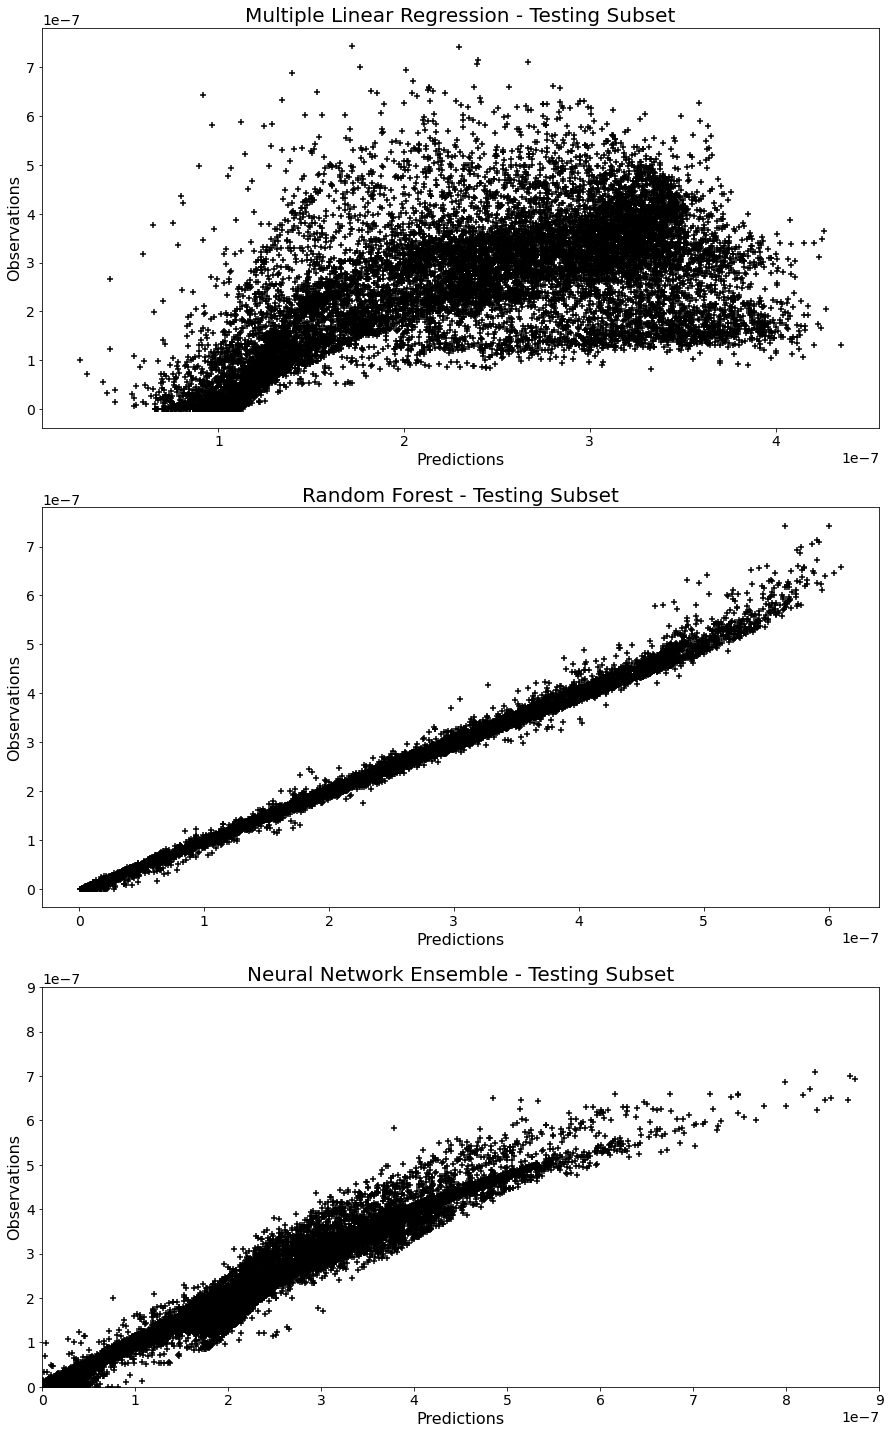

In [24]:
fig, axs = plt.subplots(3,1,figsize=(15,25))

axs[0].scatter(mlr_test_pred,mlr_test_true,marker='+',color='k')
axs[0].set_title('Multiple Linear Regression - Testing Subset',fontsize=20)
axs[0].set_xlabel('Predictions',fontsize=16)
axs[0].set_ylabel('Observations',fontsize=16)
axs[0].tick_params(labelsize=14)
axs[0].yaxis.offsetText.set_fontsize(14)
axs[0].xaxis.offsetText.set_fontsize(14)

axs[1].scatter(rf_test_pred,rf_test_true,marker='+',color='k')
axs[1].set_title('Random Forest - Testing Subset',fontsize=20)
axs[1].set_xlabel('Predictions',fontsize=16)
axs[1].set_ylabel('Observations',fontsize=16)
axs[1].tick_params(labelsize=14)
axs[1].yaxis.offsetText.set_fontsize(14)
axs[1].xaxis.offsetText.set_fontsize(14)

axs[2].scatter(nne_test_pred_avg,nne_test_true,marker='+',color='k')
axs[2].set_title('Neural Network Ensemble - Testing Subset',fontsize=20)
axs[2].set_xlim([0,9e-7])
axs[2].set_ylim([0,9e-7])
axs[2].set_xlabel('Predictions',fontsize=16)
axs[2].set_ylabel('Observations',fontsize=16)
axs[2].tick_params(labelsize=14)
axs[2].yaxis.offsetText.set_fontsize(14)
axs[2].xaxis.offsetText.set_fontsize(14)

There will be more code added at a later date.